In [97]:
import pandas as pd
import numpy as np
import os
import sys
import itertools
from idd_forecast_mbp import constants as rfc
from idd_forecast_mbp.helper_functions import ensure_id_columns_are_integers, read_parquet_with_integer_ids, read_income_paths, merge_dataframes
import glob

In [98]:
# import argparse

# parser = argparse.ArgumentParser(description="Add DAH Sceanrios and create draw level dataframes for forecating malaria")

# # Define arguments
# parser.add_argument("--cause", type=str, required=False, default="malaria", help="Cause (e.g., 'malaria', 'dengue')")
# parser.add_argument("--measure", type=str, required=False, default="mortality", help="Measure (e.g., 'mortality', 'incidence')")
# parser.add_argument("--ssp_scenario", type=str, required=True, help="SSP scenario (e.g., 'ssp126', 'ssp245', 'ssp585')")
# parser.add_argument("--ssp_scenario", type=str, required=True, help="SSP scenario (e.g., 'ssp126', 'ssp245', 'ssp585')")
# parser.add_argument("--dah_scenario", type=str, required=True, help="DAH scenario (e.g., 'Baseline')")
# parser.add_argument("--draw", type=str, required=True, help="Draw number (e.g., '001', '002', etc.)")


# # Parse arguments
# args = parser.parse_args()

# cause = args.cause
# measure = args.measure
# ssp_scenario = args.ssp_scenario
# dah_scenario = args.dah_scenario
# draw = args.draw

cause = "malaria"
measure = "mortality"
ssp_scenario = "ssp245"
dah_scenario = "Baseline"
draw = "001"

In [99]:
hierarchy = "lsae_1209"

ssp_scenarios = rfc.ssp_scenarios
dah_scenarios = rfc.dah_scenarios
measure_map = rfc.measure_map

PROCESSED_DATA_PATH = rfc.MODEL_ROOT / "02-processed_data"
MODELING_DATA_PATH = rfc.MODEL_ROOT / "03-modeling_data"
FORECASTING_DATA_PATH = rfc.MODEL_ROOT / "04-forecasting_data"

FHS_DATA_PATH = f"{PROCESSED_DATA_PATH}/age_specific_fhs"
hierarchy_df_path = f'{PROCESSED_DATA_PATH}/full_hierarchy_lsae_1209.parquet'
age_metadata_path = f"{FHS_DATA_PATH}/age_metadata.parquet"

as_fhs_df_template = "{MODELING_DATA_PATH}/fhs_{cause}_{measure}_{metric}_modeling_df.parquet"
cause_draw_path_template = "{FORECASTING_DATA_PATH}/{cause}_forecast_ssp_scenario_{ssp_scenario}_dah_scenario_{dah_scenario_name}_draw_{draw}_with_predictions.parquet"
output_cause_draw_path_template = "{FORECASTING_DATA_PATH}/as_{cause}_measure_{measure}_ssp_scenario_{ssp_scenario}_dah_scenario_{dah_scenario_name}_draw_{draw}_with_predictions.parquet"

In [100]:
###----------------------------------------------------------###
### 5. Age Metadata Processing
### Loads age group metadata and creates all possible age-sex combinations
### for disaggregation of all-age population values.
###----------------------------------------------------------###
age_metadata_df = read_parquet_with_integer_ids(age_metadata_path)
age_group_ids = age_metadata_df["age_group_id"].unique()
sex_ids = [1, 2]  # 1
combinations = list(itertools.product(age_group_ids, sex_ids))
as_df = pd.DataFrame(combinations, columns=['age_group_id', 'sex_id'])

df = read_parquet_with_integer_ids(
    cause_draw_path_template.format(
        FORECASTING_DATA_PATH=FORECASTING_DATA_PATH,
        cause=cause,
        ssp_scenario=ssp_scenario,
        dah_scenario_name=dah_scenario,
        draw=draw
    )
)

short = measure_map[measure]["short"]
df_columns = [col for col in df.columns if short in col]
df_columns = ['location_id', 'year_id', 'population', 'location_name',
       'fhs_location_id'] + df_columns
df = df[df_columns].copy()
# Find the column with "pred" in it and save that column name
pred_raw_col = [col for col in df.columns if "pred_raw" in col][0]
# Set _pred_raw to ""
obs_col = pred_raw_col.replace("_pred_raw", "")
pred_col = pred_raw_col.replace("_pred_raw", "_pred")

In [101]:

as_fhs_df = read_parquet_with_integer_ids(
    as_fhs_df_template.format(
        MODELING_DATA_PATH=MODELING_DATA_PATH,
        cause=cause,
        measure=measure,
        metric="count"
    )
)

In [102]:
reference_age_group_id = as_fhs_df["reference_age_group_id"].unique()[0]
reference_sex_id = as_fhs_df["reference_sex_id"].unique()[0]

as_fhs_0_df = as_fhs_df[
    (as_fhs_df["age_group_id"] == reference_age_group_id) &
    (as_fhs_df["sex_id"] == reference_sex_id)].copy()
as_fhs_0_df = as_fhs_0_df[["location_id", "risk_0", "year_id"]]
as_fhs_0_df = as_fhs_0_df.rename(columns={"location_id": "fhs_location_id"})
as_fhs_0_df = as_fhs_0_df.rename(columns={"risk_0": f"{cause}_{short}_rate_baseline"})
as_fhs_0_df[obs_col] = np.log(as_fhs_0_df[f"{cause}_{short}_rate_baseline"] + 1e-6)

In [103]:

df = df.merge(
    as_fhs_0_df,
    on=["fhs_location_id", "year_id"],
    how="left")

In [104]:
df_2022 = df[df["year_id"] == 2022].copy()

df_2022["shift"] = df_2022[obs_col] - df_2022[pred_raw_col]
df_2022["shift"] = df_2022["shift"].fillna(0)



In [105]:
df = df.merge(
    df_2022[["location_id", "shift"]],
    on=["location_id"],
    how="left"
)

In [106]:
df

,location_id,year_id,population,location_name,fhs_location_id,log_malaria_mort_rate_pred_raw,malaria_mort_rate_baseline,log_malaria_mort_rate,shift
0,25355,2000,146343.203125,Aba North Local Government Area,25318,-1.486403,0.006568,-5.025328,-3.432214
1,25355,2001,149733.796875,Aba North Local Government Area,25318,-1.471251,0.006662,-5.011147,-3.432214
2,25355,2002,153356.593750,Aba North Local Government Area,25318,-1.505900,0.006811,-4.989040,-3.432214
3,25355,2003,157241.343750,Aba North Local Government Area,25318,-1.525674,0.006707,-5.004461,-3.432214
4,25355,2004,161380.968750,Aba North Local Government Area,25318,-1.587375,0.006801,-4.990505,-3.432214
...,...,...,...,...,...,...,...,...,...
1721946,96234,2096,463697.750000,"Larut, Matang, and Selama",13,-9.488677,NaN,NaN,-3.635306
1721947,96234,2097,461875.093750,"Larut, Matang, and Selama",13,-9.488983,NaN,NaN,-3.635306
1721948,96234,2098,460007.343750,"Larut, Matang, and Selama",13,-9.489432,NaN,NaN,-3.635306
1721949,96234,2099,458109.187500,"Larut, Matang, and Selama",13,-9.490024,NaN,NaN,-3.635306


In [107]:
df[pred_col] = df[pred_raw_col] + df["shift"]
df[f"{cause}_{short}_rate_pred"] = np.exp(df[pred_col])



In [108]:
# Drop all columns that have "log" in them
df = df.drop(columns=[col for col in df.columns if "log" in col])
# Drop all columns that have shift in them
df = df.drop(columns=[col for col in df.columns if "shift" in col])

as_fhs_2022_df = as_fhs_df[as_fhs_df["year_id"] == 2022].copy()


In [110]:
# Set as_fhs_2022_df relatve_risk_as that is NaN to 1
as_fhs_2022_df["relative_risk_as"] = as_fhs_2022_df["relative_risk_as"].fillna(0)
as_fhs_2022_df = as_fhs_2022_df.rename(columns={"location_id": "fhs_location_id"})

In [111]:
as_fhs_2022_df

,fhs_location_id,year_id,age_group_id,sex_id,val,population,population_aa,aa_val,risk_as,reference_age_group_id,reference_sex_id,risk_0,relative_risk_as,most_detailed_fhs
21,4726,2022,2,2,0.000000,474.862579,4.527822e+06,0.465694,0.000000e+00,19,1,2.407191e-07,0.000000,1
53,44858,2022,2,1,NaN,7792.544513,2.421714e+07,NaN,NaN,19,1,NaN,0.000000,1
81,550,2022,2,1,0.000000,240.823859,1.987869e+06,0.000000,0.000000e+00,19,1,0.000000e+00,1.000000,1
107,558,2022,2,1,0.000000,1270.965750,1.183534e+07,0.000000,0.000000e+00,19,1,0.000000e+00,1.000000,1
122,492,2022,2,2,0.000000,1086.055305,2.160718e+07,0.000000,0.000000e+00,19,1,0.000000e+00,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612143,108,2022,389,2,0.000000,1856.825344,4.333913e+05,0.000000,0.000000e+00,19,1,0.000000e+00,1.000000,1
612199,4844,2022,389,1,2.754755,666403.876907,1.294773e+08,55.315391,4.133762e-06,19,1,5.594405e-07,7.389100,1
612240,10,2022,389,2,0.041954,88022.965563,1.715549e+07,3.566152,4.766269e-07,19,1,4.546603e-07,1.048314,1
612277,211,2022,389,1,1173.831565,255821.455125,2.496446e+07,18362.036650,4.588480e-03,19,1,2.234558e-03,2.053417,1


In [ ]:


malaria_measure_full_df = malaria_measure_df.merge(as_df, how = "cross")
# Drop population column
malaria_measure_full_df = malaria_measure_full_df.drop(columns=["population"])

malaria_measure_full_df["reference_age_group_id"] = reference_age_group_id
malaria_measure_full_df["reference_sex_id"] = reference_sex_id

malaria_measure_full_df = malaria_measure_full_df.merge(
    as_fhs_2022_df[["fhs_location_id", "age_group_id", "sex_id", "relative_risk_as"]],
    on=["fhs_location_id", "age_group_id", "sex_id"],
    how="left"
)


In [ ]:




malaria_measure_full_df["rate_pred"] = malaria_measure_full_df[f"malaria_mort_rate_baseline_pred"] * malaria_measure_full_df["relative_risk_as"]

# Make filters based on FHS hierarchy
malaria_location_ids = malaria_df["location_id"].unique()
year_ids = malaria_df["year_id"].unique()
malaria_location_filter = ('location_id', 'in', malaria_location_ids)
year_filter = ('year_id', 'in', year_ids)

as_lsae_population_df_path = f"{MODELING_DATA_PATH}/as_lsae_population_df.parquet"

# Read FHS population data with filters
as_lsae_population_df = read_parquet_with_integer_ids(
    as_lsae_population_df_path,
    filters=[[malaria_location_filter, year_filter]]  # Combining with AND logic
)

malaria_measure_full_df = malaria_measure_full_df.merge(
    as_lsae_population_df[["location_id", "year_id", "population_aa", "age_group_id", "sex_id", "pop_fraction_aa", "population"]],
    on=["location_id", "year_id", "age_group_id", "sex_id"],
    how="left")

malaria_measure_full_df["count_pred"] = malaria_measure_full_df["rate_pred"] * malaria_measure_full_df["population"]
malaria_measure_full_df["count_pred"] = malaria_measure_full_df["count_pred"].fillna(0)

# Write the final DataFrame to a parquet file
# Don't make any new changes, just write it out
# Don't run ensure 
output_path = output_malaria_draw_path.format(
    FORECASTING_DATA_PATH=FORECASTING_DATA_PATH,
    measure=measure,
    ssp_scenario=ssp_scenario,
    dah_scenario_name=dah_scenario,
    draw=draw
)
malaria_measure_full_df.to_parquet(output_path, compression="snappy", index=False)

In [15]:
measure = "mortality"
short = measure_map[measure]["short"]
df_columns = [col for col in df.columns if short in col]
df_columns = ['location_id', 'year_id', 'population', 'location_name',
       'fhs_location_id'] + df_columns
df = df[df_columns].copy()

In [16]:
metric = "count"
as_fhs_df = read_parquet_with_integer_ids(
    as_df_path.format(
        MODELING_DATA_PATH=MODELING_DATA_PATH,
        cause=cause,
        measure=measure,
        metric=metric
    )
)

In [ ]:



reference_age_group_id = as_fhs_df["reference_age_group_id"].unique()[0]
reference_sex_id = as_fhs_df["reference_sex_id"].unique()[0]

as_fhs_0_df = as_fhs_df[
    (as_fhs_df["age_group_id"] == reference_age_group_id) &
    (as_fhs_df["sex_id"] == reference_sex_id)].copy()
as_fhs_0_df = as_fhs_0_df[["location_id", "risk_0", "year_id"]]
as_fhs_0_df = as_fhs_0_df.rename(columns={"location_id": "fhs_location_id"})
as_fhs_0_df = as_fhs_0_df.rename(columns={"risk_0": f"{cause}_{short}_rate_baseline"})
as_fhs_0_df[f"log_malaria_{short}_rate"] = np.log(as_fhs_0_df[f"malaria_{short}_rate_baseline"] + 1e-6)


In [10]:
malaria_measure_df.columns

Index(['log_malaria_mort_rate_pred_1_raw', 'log_malaria_mort_rate_pred_2_raw'], dtype='object')

In [ ]:

malaria_measure_df = malaria_measure_df.merge(
    as_fhs_0_df,
    on=["fhs_location_id", "year_id"],
    how="left")


In [ ]:

malaria_measure_2022_df = malaria_measure_df[malaria_measure_df["year_id"] == 2022].copy()

malaria_measure_2022_df["shift_1"] = malaria_measure_2022_df["log_malaria_mort_rate"] - malaria_measure_2022_df["log_malaria_mort_rate_pred_1_raw"]
malaria_measure_2022_df["shift_2"] = malaria_measure_2022_df["log_malaria_mort_rate"] - malaria_measure_2022_df["log_malaria_mort_rate_pred_2_raw"]
malaria_measure_2022_df["shift_1"] = malaria_measure_2022_df["shift_1"].fillna(0)
malaria_measure_2022_df["shift_2"] = malaria_measure_2022_df["shift_2"].fillna(0)

malaria_measure_df = malaria_measure_df.merge(
    malaria_measure_2022_df[["location_id", "shift_1", "shift_2"]],
    on=["location_id"],
    how="left"
)

In [ ]:



malaria_measure_df[f"log_malaria_{short}_rate_pred_1"] = malaria_measure_df[f"log_malaria_{short}_rate_pred_1_raw"] + malaria_measure_df["shift_1"]
malaria_measure_df[f"log_malaria_{short}_rate_pred_2"] = malaria_measure_df[f"log_malaria_{short}_rate_pred_2_raw"] + malaria_measure_df["shift_2"]

malaria_measure_df[f"malaria_{short}_rate_baseline_pred_1"] = np.exp(malaria_measure_df[f"log_malaria_{short}_rate_pred_1"])
malaria_measure_df[f"malaria_{short}_rate_baseline_pred_2"] = np.exp(malaria_measure_df[f"log_malaria_{short}_rate_pred_2"])

# Drop all columns that have "log" in them
malaria_measure_df = malaria_measure_df.drop(columns=[col for col in malaria_measure_df.columns if "log" in col])
# Drop all columns that have shift in them
malaria_measure_df = malaria_measure_df.drop(columns=[col for col in malaria_measure_df.columns if "shift" in col])

as_fhs_2022_df = as_fhs_df[as_fhs_df["year_id"] == 2022].copy()

# Set as_fhs_2022_df relatve_risk_as that is NaN to 1
as_fhs_2022_df["relative_risk_as"] = as_fhs_2022_df["relative_risk_as"].fillna(1)
as_fhs_2022_df = as_fhs_2022_df.rename(columns={"location_id": "fhs_location_id"})

malaria_measure_full_df = malaria_measure_df.merge(as_df, how = "cross")
# Drop population column
malaria_measure_full_df = malaria_measure_full_df.drop(columns=["population"])

malaria_measure_full_df["reference_age_group_id"] = reference_age_group_id
malaria_measure_full_df["reference_sex_id"] = reference_sex_id

malaria_measure_full_df = malaria_measure_full_df.merge(
    as_fhs_2022_df[["fhs_location_id", "age_group_id", "sex_id", "relative_risk_as"]],
    on=["fhs_location_id", "age_group_id", "sex_id"],
    how="left"
)

malaria_measure_full_df["rate_pred_1"] = malaria_measure_full_df["malaria_mort_rate_baseline_pred_1"] * malaria_measure_full_df["relative_risk_as"]
malaria_measure_full_df["rate_pred_2"] = malaria_measure_full_df["malaria_mort_rate_baseline_pred_2"] * malaria_measure_full_df["relative_risk_as"]

# Make filters based on FHS hierarchy
malaria_location_ids = malaria_df["location_id"].unique()
year_ids = malaria_df["year_id"].unique()
malaria_location_filter = ('location_id', 'in', malaria_location_ids)
year_filter = ('year_id', 'in', year_ids)

as_lsae_population_df_path = f"{MODELING_DATA_PATH}/as_lsae_population_df.parquet"

# Read FHS population data with filters
as_lsae_population_df = read_parquet_with_integer_ids(
    as_lsae_population_df_path,
    filters=[[malaria_location_filter, year_filter]]  # Combining with AND logic
)

malaria_measure_full_df = malaria_measure_full_df.merge(
    as_lsae_population_df[["location_id", "year_id", "population_aa", "age_group_id", "sex_id", "pop_fraction_aa", "population"]],
    on=["location_id", "year_id", "age_group_id", "sex_id"],
    how="left")

malaria_measure_full_df["count_pred_1"] = malaria_measure_full_df["rate_pred_1"] * malaria_measure_full_df["population"]
malaria_measure_full_df["count_pred_2"] = malaria_measure_full_df["rate_pred_2"] * malaria_measure_full_df["population"]
malaria_measure_full_df["count_pred_1"] = malaria_measure_full_df["count_pred_1"].fillna(0)
malaria_measure_full_df["count_pred_2"] = malaria_measure_full_df["count_pred_2"].fillna(0)

# Write the final DataFrame to a parquet file
# Don't make any new changes, just write it out
# Don't run ensure 
output_path = output_malaria_draw_path.format(
    FORECASTING_DATA_PATH=FORECASTING_DATA_PATH,
    measure=measure,
    ssp_scenario=ssp_scenario,
    dah_scenario_name=dah_scenario,
    draw=draw
)
malaria_measure_full_df.to_parquet(output_path, index=False)

KeyError: 'fhs_location_id'

In [ ]:


for measure in measure_map:
    short = measure_map[measure]["short"]
    malaria_df_columns = [col for col in malaria_df.columns if short in col]
    malaria_measure_df = malaria_df[malaria_df_columns].copy()

    metric = "count"
    as_fhs_df = read_parquet_with_integer_ids(
        as_df_path.format(
            MODELING_DATA_PATH=MODELING_DATA_PATH,
            cause=cause,
            measure=measure,
            metric=metric
        )
    )
    
    reference_age_group_id = as_fhs_df["reference_age_group_id"].unique()[0]
    reference_sex_id = as_fhs_df["reference_sex_id"].unique()[0]

    as_fhs_0_df = as_fhs_df[
        (as_fhs_df["age_group_id"] == reference_age_group_id) &
        (as_fhs_df["sex_id"] == reference_sex_id)].copy()
    as_fhs_0_df = as_fhs_0_df[["location_id", "risk_0", "year_id"]]
    as_fhs_0_df = as_fhs_0_df.rename(columns={"location_id": "fhs_location_id"})
    as_fhs_0_df = as_fhs_0_df.rename(columns={"risk_0": f"malaria_{short}_rate_baseline"})
    as_fhs_0_df[f"log_malaria_{short}_rate"] = np.log(as_fhs_0_df[f"malaria_{short}_rate_baseline"] + 1e-6)

    malaria_measure_df = malaria_measure_df.merge(
        as_fhs_0_df,
        on=["fhs_location_id", "year_id"],
        how="left")

    malaria_measure_2022_df = malaria_measure_df[malaria_measure_df["year_id"] == 2022].copy()

    malaria_measure_2022_df["shift_1"] = malaria_measure_2022_df["log_malaria_mort_rate"] - malaria_measure_2022_df["log_malaria_mort_rate_pred_1_raw"]
    malaria_measure_2022_df["shift_2"] = malaria_measure_2022_df["log_malaria_mort_rate"] - malaria_measure_2022_df["log_malaria_mort_rate_pred_2_raw"]
    malaria_measure_2022_df["shift_1"] = malaria_measure_2022_df["shift_1"].fillna(0)
    malaria_measure_2022_df["shift_2"] = malaria_measure_2022_df["shift_2"].fillna(0)

    malaria_measure_df = malaria_measure_df.merge(
        malaria_measure_2022_df[["location_id", "shift_1", "shift_2"]],
        on=["location_id"],
        how="left"
    )

    malaria_measure_df[f"log_malaria_{short}_rate_pred_1"] = malaria_measure_df[f"log_malaria_{short}_rate_pred_1_raw"] + malaria_measure_df["shift_1"]
    malaria_measure_df[f"log_malaria_{short}_rate_pred_2"] = malaria_measure_df[f"log_malaria_{short}_rate_pred_2_raw"] + malaria_measure_df["shift_2"]

    malaria_measure_df[f"malaria_{short}_rate_baseline_pred_1"] = np.exp(malaria_measure_df[f"log_malaria_{short}_rate_pred_1"])
    malaria_measure_df[f"malaria_{short}_rate_baseline_pred_2"] = np.exp(malaria_measure_df[f"log_malaria_{short}_rate_pred_2"])

    # Drop all columns that have "log" in them
    malaria_measure_df = malaria_measure_df.drop(columns=[col for col in malaria_measure_df.columns if "log" in col])
    # Drop all columns that have shift in them
    malaria_measure_df = malaria_measure_df.drop(columns=[col for col in malaria_measure_df.columns if "shift" in col])

    as_fhs_2022_df = as_fhs_df[as_fhs_df["year_id"] == 2022].copy()

    # Set as_fhs_2022_df relatve_risk_as that is NaN to 1
    as_fhs_2022_df["relative_risk_as"] = as_fhs_2022_df["relative_risk_as"].fillna(1)
    as_fhs_2022_df = as_fhs_2022_df.rename(columns={"location_id": "fhs_location_id"})

    malaria_measure_full_df = malaria_measure_df.merge(as_df, how = "cross")
    # Drop population column
    malaria_measure_full_df = malaria_measure_full_df.drop(columns=["population"])

    malaria_measure_full_df["reference_age_group_id"] = reference_age_group_id
    malaria_measure_full_df["reference_sex_id"] = reference_sex_id

    malaria_measure_full_df = malaria_measure_full_df.merge(
        as_fhs_2022_df[["fhs_location_id", "age_group_id", "sex_id", "relative_risk_as"]],
        on=["fhs_location_id", "age_group_id", "sex_id"],
        how="left"
    )

    malaria_measure_full_df["rate_pred_1"] = malaria_measure_full_df["malaria_mort_rate_baseline_pred_1"] * malaria_measure_full_df["relative_risk_as"]
    malaria_measure_full_df["rate_pred_2"] = malaria_measure_full_df["malaria_mort_rate_baseline_pred_2"] * malaria_measure_full_df["relative_risk_as"]

    # Make filters based on FHS hierarchy
    malaria_location_ids = malaria_df["location_id"].unique()
    year_ids = malaria_df["year_id"].unique()
    malaria_location_filter = ('location_id', 'in', malaria_location_ids)
    year_filter = ('year_id', 'in', year_ids)

    as_lsae_population_df_path = f"{MODELING_DATA_PATH}/as_lsae_population_df.parquet"

    # Read FHS population data with filters
    as_lsae_population_df = read_parquet_with_integer_ids(
        as_lsae_population_df_path,
        filters=[[malaria_location_filter, year_filter]]  # Combining with AND logic
    )

    malaria_measure_full_df = malaria_measure_full_df.merge(
        as_lsae_population_df[["location_id", "year_id", "population_aa", "age_group_id", "sex_id", "pop_fraction_aa", "population"]],
        on=["location_id", "year_id", "age_group_id", "sex_id"],
        how="left")

    malaria_measure_full_df["count_pred_1"] = malaria_measure_full_df["rate_pred_1"] * malaria_measure_full_df["population"]
    malaria_measure_full_df["count_pred_2"] = malaria_measure_full_df["rate_pred_2"] * malaria_measure_full_df["population"]
    malaria_measure_full_df["count_pred_1"] = malaria_measure_full_df["count_pred_1"].fillna(0)
    malaria_measure_full_df["count_pred_2"] = malaria_measure_full_df["count_pred_2"].fillna(0)

    # Write the final DataFrame to a parquet file
    # Don't make any new changes, just write it out
    # Don't run ensure 
    output_path = output_malaria_draw_path.format(
        FORECASTING_DATA_PATH=FORECASTING_DATA_PATH,
        measure=measure,
        ssp_scenario=ssp_scenario,
        dah_scenario_name=dah_scenario,
        draw=draw
    )
    malaria_measure_full_df.to_parquet(output_path, index=False)

KeyError: 'fhs_location_id'

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import itertools
from idd_forecast_mbp import constants as rfc
from idd_forecast_mbp.helper_functions import ensure_id_columns_are_integers, read_parquet_with_integer_ids, read_income_paths, merge_dataframes
import glob

hierarchy = "lsae_1209"

ssp_scenarios = rfc.ssp_scenarios
dah_scenarios = rfc.dah_scenarios
draws = rfc.draws


In [2]:
PROCESSED_DATA_PATH = rfc.MODEL_ROOT / "02-processed_data"
MODELING_DATA_PATH = rfc.MODEL_ROOT / "03-modeling_data"
FORECASTING_DATA_PATH = rfc.MODEL_ROOT / "04-forecasting_data"


FHS_DATA_PATH = f"{PROCESSED_DATA_PATH}/age_specific_fhs"
hierarchy_df_path = f'{PROCESSED_DATA_PATH}/full_hierarchy_lsae_1209.parquet'
age_metadata_path = f"{FHS_DATA_PATH}/age_metadata.parquet"


as_df_path = "{MODELING_DATA_PATH}/fhs_{cause}_{measure}_{metric}_modeling_df.parquet"
malaria_draw_path = "{FORECASTING_DATA_PATH}/malaria_forecast_ssp_scenario_{ssp_scenario}_dah_scenario_{dah_scenario_name}_draw_{draw}_with_predictions.parquet"

In [3]:
ssp_scenario = list(ssp_scenarios.keys())[1]
dah_scenario = list(dah_scenarios.keys())[0]
draw = draws[0]



In [4]:
###----------------------------------------------------------###
### 5. Age Metadata Processing
### Loads age group metadata and creates all possible age-sex combinations
### for disaggregation of all-age population values.
###----------------------------------------------------------###
age_metadata_df = read_parquet_with_integer_ids(age_metadata_path)
age_group_ids = age_metadata_df["age_group_id"].unique()
sex_ids = [1, 2]  # 1
combinations = list(itertools.product(age_group_ids, sex_ids))
as_df = pd.DataFrame(combinations, columns=['age_group_id', 'sex_id'])


In [5]:
cause = "malaria"
measure = "mortality"
metric = "count"
as_fhs_df = read_parquet_with_integer_ids(
    as_df_path.format(
        MODELING_DATA_PATH=MODELING_DATA_PATH,
        cause=cause,
        measure=measure,
        metric=metric
    )
)


In [6]:
malaria_df = read_parquet_with_integer_ids(
    malaria_draw_path.format(
        FORECASTING_DATA_PATH=FORECASTING_DATA_PATH,
        ssp_scenario=ssp_scenario,
        dah_scenario_name=dah_scenario,
        draw=draw
    )
)

In [7]:
malaria_df = read_parquet_with_integer_ids(
    malaria_draw_path.format(
        FORECASTING_DATA_PATH=FORECASTING_DATA_PATH,
        ssp_scenario=ssp_scenario,
        dah_scenario_name=dah_scenario,
        draw=draw
    )
)
malaria_df = malaria_df.drop(columns=["people_flood_days", "people_flood_days_per_capita", "location_set_version_id", "scenario","fhs_level",
                                      "location_set_id","is_estimate","sort_order",'location_type', 'map_id', 'super_region_id', 'super_region_name',
       'region_id', 'region_name', 'ihme_loc_id', 'local_id', 'path_to_top_parent', 'parent_id', 'logit_malaria_pfpr_pred_1_raw', 'logit_malaria_pfpr_pred_2_raw',
       'most_detailed_lsae', 'in_fhs_hierarchy', 'in_lsae_hierarchy', 'logit_malaria_pfpr_pred_1','logit_malaria_pfpr_pred_2','logit_malaria_pfpr_obs',
       'in_gbd_hierarchy', 'most_detailed_gbd', 'most_detailed_fhs', 'malaria_pfpr', 'A0_location_id','level',
       'gbd_location_id', 'gbd_level', 'mal_DAH_total', 'draw', 'ssp_scenario','dah_scenario',
       'mal_DAH_total_per_capita', 'gdppc_mean', 'total_precipitation',
       'malaria_suitability', 'log_mal_DAH_total_per_capita', 'log_gdppc_mean',
       'stage_2', 'A0_af'])

malaria_incidence_columns = [col for col in malaria_df.columns if "mort" not in col]
malaria_mortality_columns = [col for col in malaria_df.columns if "inc" not in col]

malaria_mortality_df = malaria_df[malaria_mortality_columns].copy()
malaria_incidence_df = malaria_df[malaria_incidence_columns].copy()

In [8]:
reference_age_group_id = as_fhs_df["reference_age_group_id"].unique()[0]
reference_sex_id = as_fhs_df["reference_sex_id"].unique()[0]

as_fhs_0_df = as_fhs_df[
    (as_fhs_df["age_group_id"] == reference_age_group_id) &
    (as_fhs_df["sex_id"] == reference_sex_id)].copy()
as_fhs_0_df = as_fhs_0_df[["location_id", "risk_0", "year_id"]]
as_fhs_0_df = as_fhs_0_df.rename(columns={"location_id": "fhs_location_id"})
as_fhs_0_df = as_fhs_0_df.rename(columns={"risk_0": "malaria_mort_rate_baseline"})
as_fhs_0_df["log_malaria_mort_rate"] = np.log(as_fhs_0_df["malaria_mort_rate_baseline"] + 1e-6)

In [9]:

malaria_mortality_df = malaria_mortality_df.merge(
    as_fhs_0_df,
    on=["fhs_location_id", "year_id"],
    how="left")



In [10]:
plot_df = malaria_mortality_df.copy()
# Keep only rows that are not NaN in the log_malaria_mort_rate column
plot_df = plot_df[plot_df["log_malaria_mort_rate"].notna()]


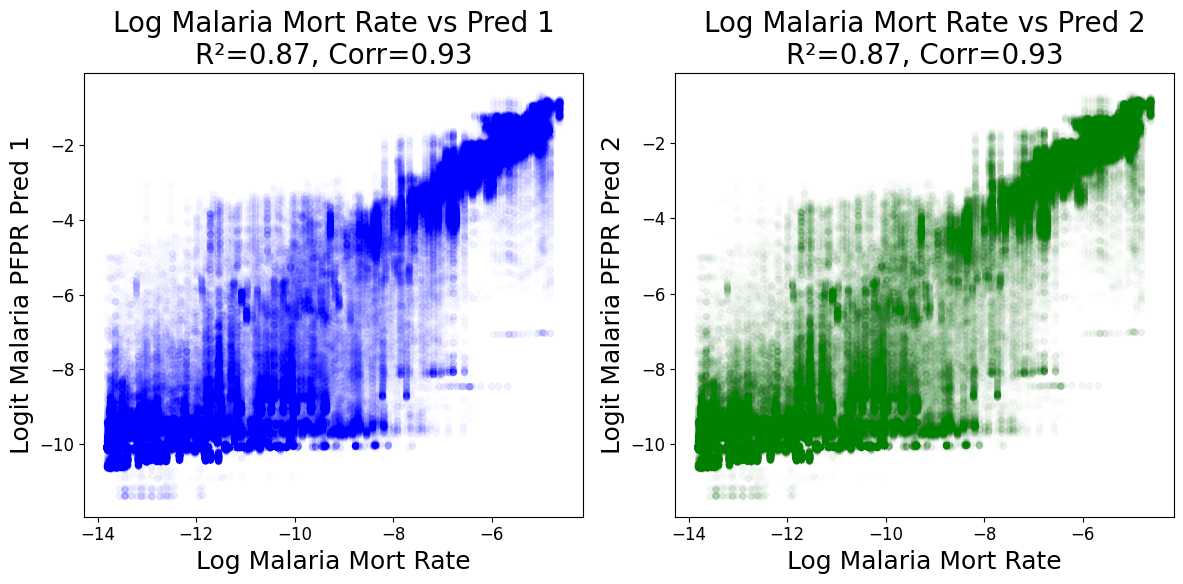

In [11]:
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import numpy as np

import matplotlib.pyplot as plt

# Prepare data, dropping NaNs for each plot
x = plot_df["log_malaria_mort_rate"]
y1 = plot_df["log_malaria_mort_rate_pred_1_raw"]
y2 = plot_df["log_malaria_mort_rate_pred_2_raw"]

# Drop NaNs for each pair
mask1 = x.notna() & y1.notna()
mask2 = x.notna() & y2.notna()

x1, y1 = x[mask1], y1[mask1]
x2, y2 = x[mask2], y2[mask2]

# Compute correlation and R^2 for panel 1
corr1, _ = pearsonr(x1, y1)
reg1 = LinearRegression().fit(x1.values.reshape(-1, 1), y1.values)
r2_1 = reg1.score(x1.values.reshape(-1, 1), y1.values)

# Compute correlation and R^2 for panel 2
corr2, _ = pearsonr(x2, y2)
reg2 = LinearRegression().fit(x2.values.reshape(-1, 1), y2.values)
r2_2 = reg2.score(x2.values.reshape(-1, 1), y2.values)


plt.rcParams.update({'font.size': 12})  # Set default font size larger

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(x1, y1, alpha=0.01, s=20, color='blue')  # Increase marker size for visibility
plt.xlabel("Log Malaria Mort Rate", fontsize=18)
plt.ylabel("Logit Malaria PFPR Pred 1", fontsize=18)
plt.title(f"Log Malaria Mort Rate vs Pred 1\nR²={r2_1:.2f}, Corr={corr1:.2f}", fontsize=20)

plt.subplot(1, 2, 2)
plt.scatter(x2, y2, alpha=0.01, s=20, color='green')
plt.xlabel("Log Malaria Mort Rate", fontsize=18)
plt.ylabel("Logit Malaria PFPR Pred 2", fontsize=18)
plt.title(f"Log Malaria Mort Rate vs Pred 2\nR²={r2_2:.2f}, Corr={corr2:.2f}", fontsize=20)

plt.tight_layout()
plt.show()


In [12]:
malaria_mortality_2022_df = malaria_mortality_df[malaria_mortality_df["year_id"] == 2022].copy()
malaria_incidence_2022_df = malaria_incidence_df[malaria_incidence_df["year_id"] == 2022].copy()

malaria_mortality_2022_df["shift_1"] = malaria_mortality_2022_df["log_malaria_mort_rate"] - malaria_mortality_2022_df["log_malaria_mort_rate_pred_1_raw"]
malaria_mortality_2022_df["shift_2"] = malaria_mortality_2022_df["log_malaria_mort_rate"] - malaria_mortality_2022_df["log_malaria_mort_rate_pred_2_raw"]
malaria_mortality_2022_df["shift_1"] = malaria_mortality_2022_df["shift_1"].fillna(0)
malaria_mortality_2022_df["shift_2"] = malaria_mortality_2022_df["shift_2"].fillna(0)

malaria_mortality_df = malaria_mortality_df.merge(
    malaria_mortality_2022_df[["location_id", "shift_1", "shift_2"]],
    on=["location_id"],
    how="left"
)
malaria_mortality_df["log_malaria_mort_rate_pred_1"] = malaria_mortality_df["log_malaria_mort_rate_pred_1_raw"] + malaria_mortality_df["shift_1"]
malaria_mortality_df["log_malaria_mort_rate_pred_2"] = malaria_mortality_df["log_malaria_mort_rate_pred_2_raw"] + malaria_mortality_df["shift_2"]

In [13]:
malaria_mortality_df["malaria_mort_rate_baseline_pred_1"] = np.exp(malaria_mortality_df["log_malaria_mort_rate_pred_1"])
malaria_mortality_df["malaria_mort_rate_baseline_pred_2"] = np.exp(malaria_mortality_df["log_malaria_mort_rate_pred_2"])
# Drop all columns that have "log" in them
malaria_mortality_df = malaria_mortality_df.drop(columns=[col for col in malaria_mortality_df.columns if "log" in col])
# Drop all columns that have shift in them
malaria_mortality_df = malaria_mortality_df.drop(columns=[col for col in malaria_mortality_df.columns if "shift" in col])


In [14]:
as_fhs_2022_df = as_fhs_df[as_fhs_df["year_id"] == 2022].copy()

In [15]:
# Set as_fhs_2022_df relatve_risk_as that is NaN to 1
as_fhs_2022_df["relative_risk_as"] = as_fhs_2022_df["relative_risk_as"].fillna(1)
as_fhs_2022_df = as_fhs_2022_df.rename(columns={"location_id": "fhs_location_id"})

In [16]:
malaria_mortality_full_df = malaria_mortality_df.merge(as_df, how = "cross")
# Drop population column
malaria_mortality_full_df = malaria_mortality_full_df.drop(columns=["population"])

In [17]:
malaria_mortality_full_df["reference_age_group_id"] = reference_age_group_id
malaria_mortality_full_df["reference_sex_id"] = reference_sex_id

In [18]:
malaria_mortality_full_df = malaria_mortality_full_df.merge(
    as_fhs_2022_df[["fhs_location_id", "age_group_id", "sex_id", "relative_risk_as"]],
    on=["fhs_location_id", "age_group_id", "sex_id"],
    how="left"
)
malaria_mortality_full_df["rate_pred_1"] = malaria_mortality_full_df["malaria_mort_rate_baseline_pred_1"] * malaria_mortality_full_df["relative_risk_as"]
malaria_mortality_full_df["rate_pred_2"] = malaria_mortality_full_df["malaria_mort_rate_baseline_pred_2"] * malaria_mortality_full_df["relative_risk_as"]

In [19]:
###----------------------------------------------------------###
### 3. Data Filtering Setup
### Creates location and time filters to efficiently process only relevant data.
### Sets up the foundation for selecting appropriate geographic units and time periods.
###----------------------------------------------------------###
# Make filters based on FHS hierarchy
malaria_location_ids = malaria_df["location_id"].unique()
year_ids = malaria_df["year_id"].unique()
malaria_location_filter = ('location_id', 'in', malaria_location_ids)
year_filter = ('year_id', 'in', year_ids)


In [20]:
as_lsae_population_df_path = f"{MODELING_DATA_PATH}/as_lsae_population_df.parquet"

In [21]:
# Read FHS population data with filters
as_lsae_population_df = read_parquet_with_integer_ids(
    as_lsae_population_df_path,
    filters=[[malaria_location_filter, year_filter]]  # Combining with AND logic
)


In [22]:
as_lsae_population_df

,location_id,year_id,population_aa,age_group_id,sex_id,fhs_location_id,pop_fraction_aa,population
0,93404,2000,509.803497,2,1,160,0.000488,0.248921
1,93404,2000,509.803497,2,2,160,0.000449,0.229119
2,93404,2000,509.803497,3,1,160,0.001429,0.728732
3,93404,2000,509.803497,3,2,160,0.001322,0.674032
4,93404,2000,509.803497,6,1,160,0.086948,44.326155
...,...,...,...,...,...,...,...,...
83617895,90857,2100,214305.015625,238,2,198,0.006887,1475.874904
83617896,90857,2100,214305.015625,388,1,198,0.003003,643.482659
83617897,90857,2100,214305.015625,388,2,198,0.002916,624.936881
83617898,90857,2100,214305.015625,389,1,198,0.003553,761.449076


In [23]:
malaria_mortality_full_df = malaria_mortality_full_df.merge(
    as_lsae_population_df[["location_id", "year_id", "population_aa", "age_group_id", "sex_id", "pop_fraction_aa", "population"]],
    on=["location_id", "year_id", "age_group_id", "sex_id"],
    how="left")

In [24]:
malaria_mortality_full_df

,location_id,year_id,location_name,fhs_location_id,malaria_mort_rate_baseline,malaria_mort_rate_baseline_pred_1,malaria_mort_rate_baseline_pred_2,age_group_id,sex_id,reference_age_group_id,reference_sex_id,relative_risk_as,rate_pred_1,rate_pred_2,population_aa,pop_fraction_aa,population
0,25355,2000,Aba North Local Government Area,25318,0.006568,0.007309,0.007315,2,1,19,1,0.000000,0.000000e+00,0.000000e+00,146343.203125,0.000320,46.894937
1,25355,2000,Aba North Local Government Area,25318,0.006568,0.007309,0.007315,2,2,19,1,0.000000,0.000000e+00,0.000000e+00,146343.203125,0.000304,44.494838
2,25355,2000,Aba North Local Government Area,25318,0.006568,0.007309,0.007315,3,1,19,1,2.446471,1.788184e-02,1.789679e-02,146343.203125,0.000941,137.772413
3,25355,2000,Aba North Local Government Area,25318,0.006568,0.007309,0.007315,3,2,19,1,2.430402,1.776438e-02,1.777924e-02,146343.203125,0.000899,131.603283
4,25355,2000,Aba North Local Government Area,25318,0.006568,0.007309,0.007315,6,1,19,1,0.076963,5.625396e-04,5.630100e-04,146343.203125,0.061920,9061.527007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86097545,96234,2100,"Larut, Matang, and Selama",13,NaN,0.000002,0.000002,238,2,19,1,0.028206,5.622141e-08,5.622125e-08,456183.187500,0.003377,1540.693085
86097546,96234,2100,"Larut, Matang, and Selama",13,NaN,0.000002,0.000002,388,1,19,1,0.203524,4.056743e-07,4.056732e-07,456183.187500,0.001489,679.225299
86097547,96234,2100,"Larut, Matang, and Selama",13,NaN,0.000002,0.000002,388,2,19,1,0.075923,1.513342e-07,1.513337e-07,456183.187500,0.001394,635.988030
86097548,96234,2100,"Larut, Matang, and Selama",13,NaN,0.000002,0.000002,389,1,19,1,0.087647,1.747022e-07,1.747016e-07,456183.187500,0.001776,810.115206


In [25]:
malaria_mortality_full_df["count_pred_1"] = malaria_mortality_full_df["rate_pred_1"] * malaria_mortality_full_df["population"]
malaria_mortality_full_df["count_pred_2"] = malaria_mortality_full_df["rate_pred_2"] * malaria_mortality_full_df["population"]
malaria_mortality_full_df["count_pred_1"] = malaria_mortality_full_df["count_pred_1"].fillna(0)
malaria_mortality_full_df["count_pred_2"] = malaria_mortality_full_df["count_pred_2"].fillna(0)

In [26]:
hierarchy_df_path = f'{PROCESSED_DATA_PATH}/full_hierarchy_lsae_1209.parquet'
hierarchy_df = read_parquet_with_integer_ids(hierarchy_df_path)
hierarchy_df = hierarchy_df[["location_id", "super_region_name"]].drop_duplicates()
malaria_mortality_full_df = malaria_mortality_full_df.merge(
    hierarchy_df,
    on="location_id",
    how="left"
)


In [27]:

super_region_dfs = []
super_region_names = malaria_mortality_full_df["super_region_name"].unique()
for super_region_name in super_region_names:
    super_region_df = malaria_mortality_full_df[malaria_mortality_full_df["super_region_name"] == super_region_name].copy()
    super_region_df = super_region_df.drop(columns=["super_region_name"])
    
    super_region_df = super_region_df.groupby("year_id").agg({
        "count_pred_1": "sum",
        "count_pred_2": "sum",
        "population": "sum"
    }).reset_index()
    super_region_df["location_id"] = f"{super_region_name}_total"
    super_region_dfs.append(super_region_df)

global_df = malaria_mortality_full_df.groupby("year_id").agg({
    "count_pred_1": "sum",
    "count_pred_2": "sum",
    "population": "sum"
}).reset_index()
global_df["location_id"] = "global_total"
super_region_dfs.append(global_df)

IndexError: index 6 is out of bounds for axis 0 with size 6

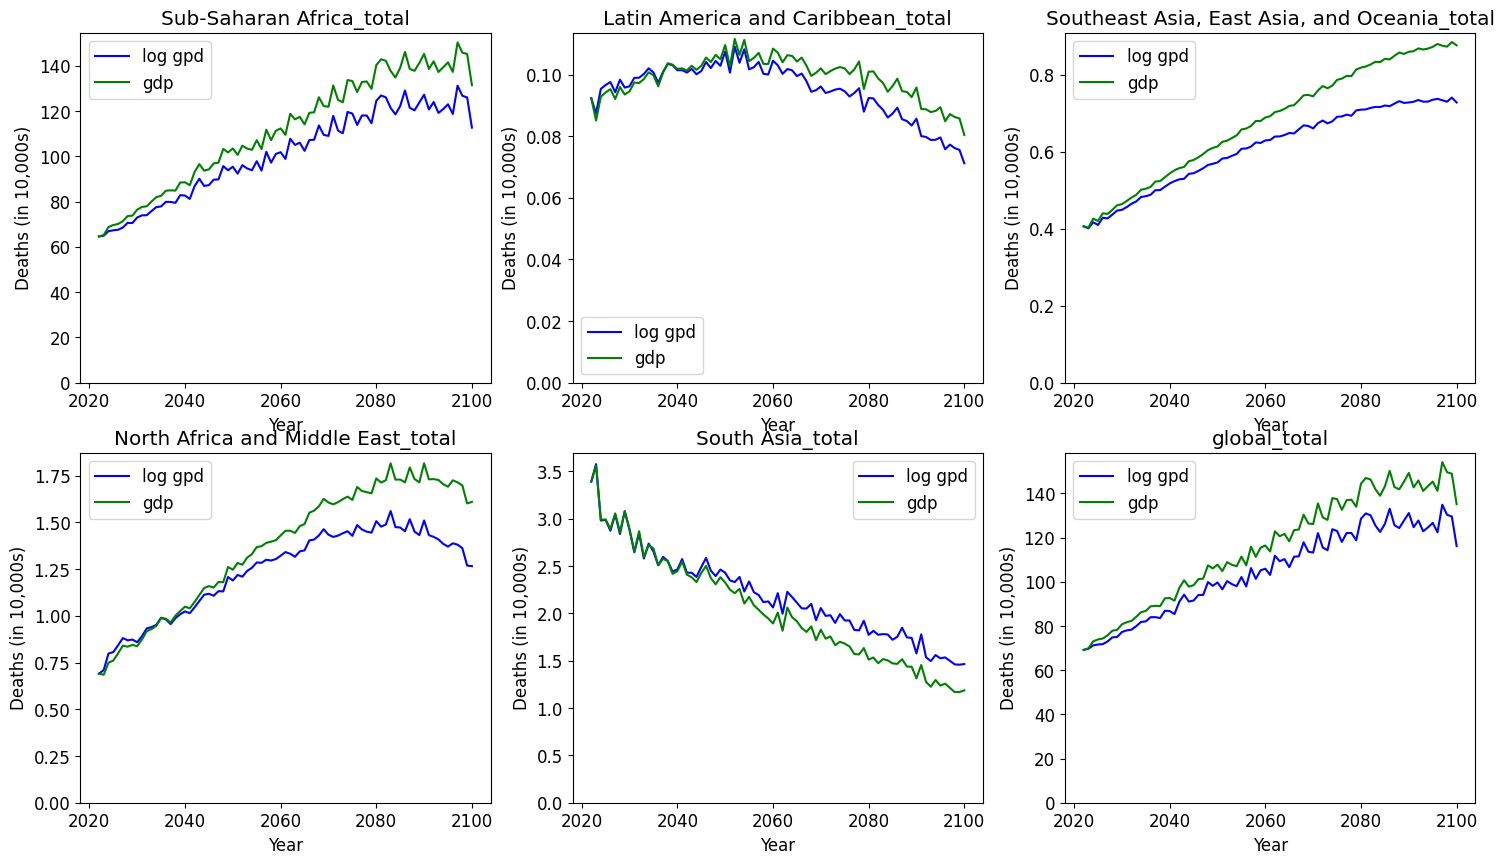

In [38]:
# Make a 2 by 3 grid of plots and plot each dataframe in super_region_dfs
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

for i, super_region_df in enumerate(super_region_dfs):
    df_plot = super_region_df[(super_region_df["year_id"] >= 2022) & (super_region_df["year_id"] <= 2100)]
    axs[i].plot(df_plot["year_id"], df_plot["count_pred_1"] / 10000, label="log gpd", color="blue")
    axs[i].plot(df_plot["year_id"], df_plot["count_pred_2"] / 10000, label="gdp", color="green")
    axs[i].set_title(df_plot["location_id"].iloc[0])
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Deaths (in 10,000s)")
    axs[i].legend()
    axs[i].set_ylim(bottom=0)

plt.tight_layout()
plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

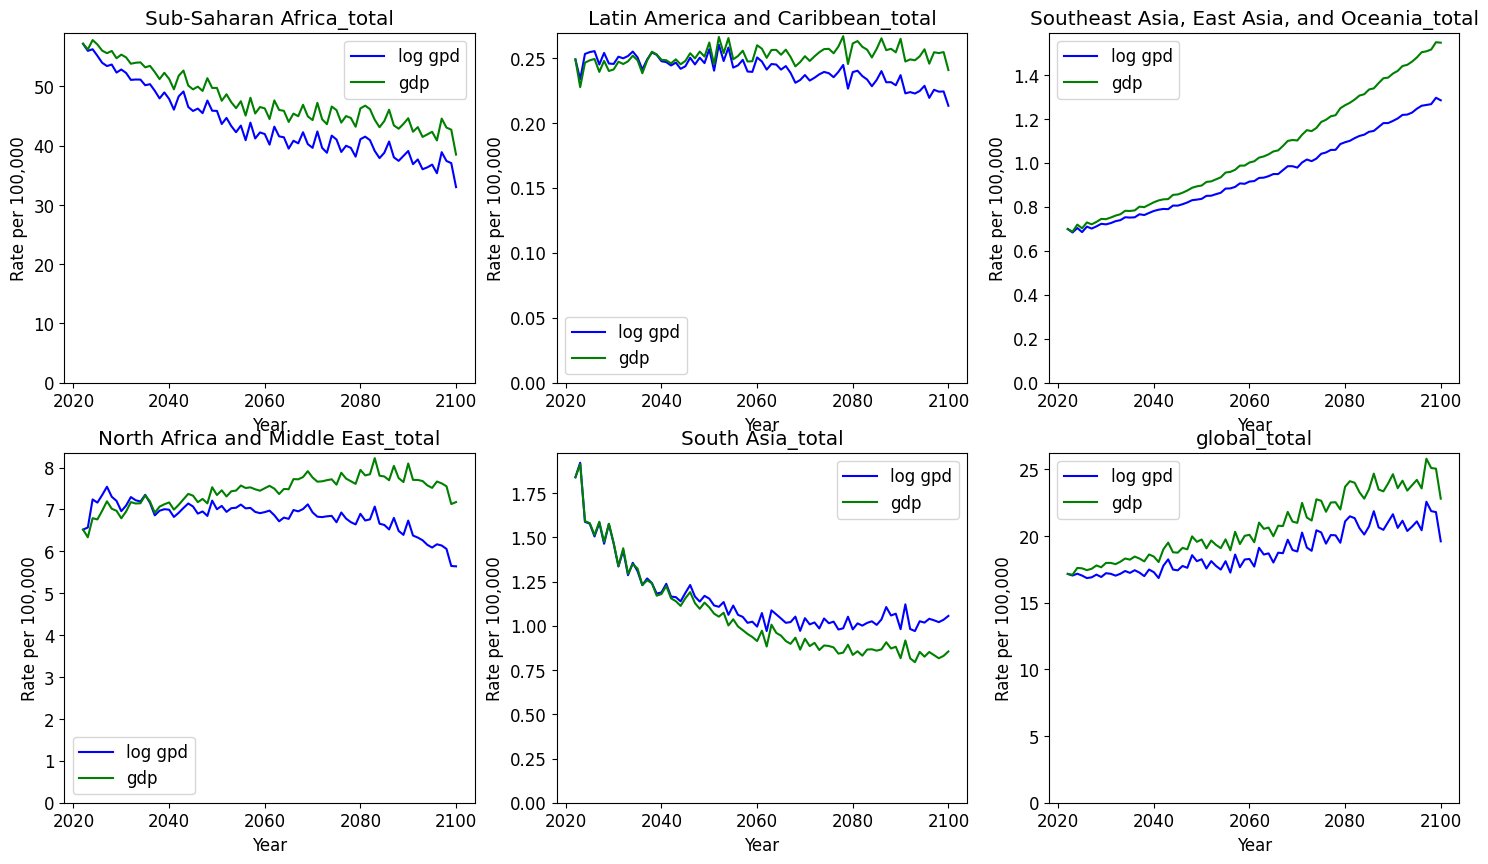

In [37]:
# Make a 2 by 3 grid of plots and plot each dataframe in super_region_dfs
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()  # Flatten the 2D array of axes to 1D for easy iteration
for i, super_region_df in enumerate(super_region_dfs):
    df_plot = super_region_df[(super_region_df["year_id"] >= 2022) & (super_region_df["year_id"] <= 2100)]
    axs[i].plot(df_plot["year_id"], 100000 * df_plot["count_pred_1"]/df_plot['population'], label="log gpd", color="blue")
    axs[i].plot(df_plot["year_id"], 100000 * df_plot["count_pred_2"]/df_plot['population'], label="gdp", color="green")
    axs[i].set_title(df_plot["location_id"].iloc[0])
    axs[i].set_xlabel("Year")
    axs[i].set_ylabel("Rate per 100,000")
    axs[i].legend()
    axs[i].set_ylim(bottom=0)
# Make the ylim lower == 0
    
plt.tight_layout()
plt.show()